# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

# TODO Check image read code on Nimble box

In [1]:
import numpy as np
import os
import skimage
#from scipy.misc import imread, imresize
import datetime
import os
import pandas as pd


from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)
from matplotlib import pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('data/Project_data/val.csv').readlines())

In [4]:
batch_size = 10 
base_path = 'data/Project_data/'

# Explore Data

In [5]:
def read_data(source):
    df = pd.read_csv(source,header=None)
    df[['folder','name','class']] = df[0].str.split(';',expand=True) 
    return df

In [6]:
def explore_data(source):
    df = read_data(source)
    print(df['class'].value_counts())

In [7]:
## Train data
explore_data(base_path+'train.csv')

1    137
3    137
0    136
2    130
4    123
Name: class, dtype: int64


In [8]:
## Val data
explore_data(base_path+'val.csv')

1    23
2    22
3    21
0    18
4    16
Name: class, dtype: int64


We can see that data is evenly balance across all the classes.

In [9]:
def get_image(folder, index):
    image_name = os.listdir(folder)[index]
    image = skimage.io.imread(folder + "/" + image_name).astype(np.float32)
    return image

In [10]:
def get_image_dimensions(row, source_path):
    y, x, _ = get_image(source_path + row['folder'], 0).shape
    return str(x) + "-" + str(y)

In [11]:
def explore_images(source_file, source_path):
    df = read_data(source_file)
    df['shape'] = df.apply(get_image_dimensions, axis=1, args=[source_path])
    print(df['shape'].value_counts())
    return df

In [12]:
# Exploring Train images
explore_images(base_path+'train.csv',base_path+'train/')

160-120    479
360-360    184
Name: shape, dtype: int64


,0,folder,name,class,shape
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
...,...,...,...,...,...
658,WIN_20180907_16_38_23_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_38_23_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
659,WIN_20180907_16_41_09_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_41_09_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
660,WIN_20180907_16_42_05_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_42_05_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
661,WIN_20180907_16_42_55_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_42_55_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360


In [13]:
# Exploring Val images
explore_images(base_path+'val.csv',base_path+'val/')

160-120    62
360-360    38
Name: shape, dtype: int64


,0,folder,name,class,shape
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new;Left_...,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_...,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new;Left_...,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_...,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0,160-120
...,...,...,...,...,...
95,WIN_20180907_15_43_36_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_15_43_36_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
96,WIN_20180907_15_52_05_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_15_52_05_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
97,WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_15_54_30_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360
98,WIN_20180907_16_10_59_Pro_Thumbs Up_new;Thumbs...,WIN_20180907_16_10_59_Pro_Thumbs Up_new,Thumbs Up_new,4,360-360


We can see there are two dimensions of the images **160*120** and **360*360**. We will need to use bring the images to same dimension when passing from generator.

## We can see that some of the images are of 120 in y dimension. So we will center crop all the image in 120X120 dimension.

In [14]:
image_shape = (120, 120)

In [15]:
def resize_image(image):
    return skimage.transform.resize(image, image_shape)

In [16]:
def crop(image):
    return image[0:120, 20:140]

In [17]:
def modify_image(image):
    if (image.shape[0] == image.shape[1]):
        return resize_image(image)
    else:
        return crop(image)

In [18]:
def crop_center(img, cropx, cropy):
    print(img.shape)
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]

160-120    479
360-360    184
Name: shape, dtype: int64


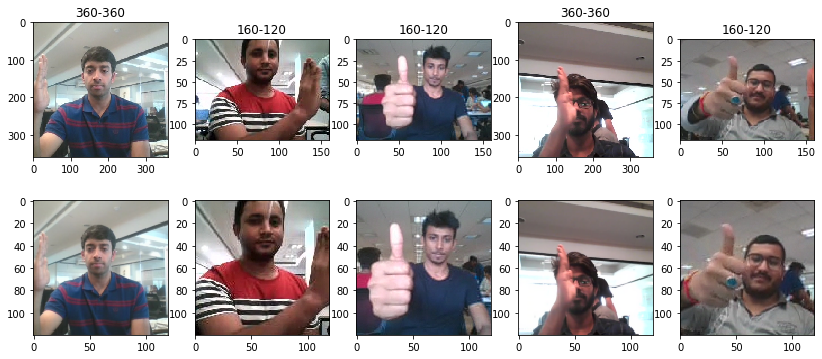

In [19]:
sample_size = 5
df = explore_images(base_path + 'train.csv', base_path + 'train/')
sample = df.sample(n=sample_size)
fig, axs = plt.subplots(2, 5, figsize=(14, 6))
plot_index = 1
for index, row in sample.head(n=sample_size).iterrows():
    image = get_image(base_path + 'train/' + row['folder'], 5)
    plt.subplot(2, 5, plot_index, title=row['shape'])
    plt.imshow(image.astype('uint8'), interpolation='nearest')
    plt.subplot(2, 5, plot_index + sample_size)
    image = modify_image(image)
    plt.imshow(image.astype('uint8'), interpolation='nearest')
    plot_index += 1

plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [20]:
list_of_images_per_video = list(range(4, 20))
train_path = base_path + 'train'
val_path = base_path + 'val'

In [21]:
def nomalize(array):
    return (array - array.min()) / (array.max() - array.min())

In [27]:
# TODO Refactor this method to remove duplicate and pass flag to append image to processedImages

def generator(source_path, folder_list, batch_size, list_of_frames=list_of_images_per_video, test_generator = False, verbose = False,processedImages = []):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list_of_frames #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches
        if verbose:
            print("Number of batches ",num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            if verbose:
                print("Executing batch ", batch)
            batch_data = np.zeros((batch_size,len(img_idx),image_shape[0],image_shape[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if verbose:
                    print("Executing folder ", folder)
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    if test_generator:
                        processedImages.append(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+"_"+str(item))
                    image = get_image(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0],item)

                    #Here, we are croping and resizing the image based on its dimensions
                    image = modify_image(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image.astype('float64')
                    batch_data[folder,idx,:,:,0] = nomalize(image[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = nomalize(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = nomalize(image[:,:,2])#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        remaining_folder = len(t)%batch_size
        if remaining_folder >0:
            batch_data = np.zeros((remaining_folder,len(img_idx),image_shape[0],image_shape[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_folder,5)) # batch_labels is the one hot representation of the output
       
            if verbose:
                print("Executing last batch ")
            for folder in range(remaining_folder): # iterate over the batch_size
                if verbose:
                    print("Executing folder ", folder)
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    if test_generator:
                        processedImages.append(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+"_"+str(item))
                    image = get_image(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0],item)

                    #Here, we are croping and resizing the image based on its dimensions
                    image = modify_image(image)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = image.astype('float64')
                    batch_data[folder,idx,:,:,0] = nomalize(image[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = nomalize(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = nomalize(image[:,:,2])#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        if test_generator:
            break;
        # write the code for the remaining data points which are left after full batches


In [28]:
def add_to_generator(isBatch, verbose=False):
    group_size = batch_size if isBatch else remaining_folder
    batch_data = np.zeros((group_size, len(img_idx), image_shape[0], image_shape[1],
                           3))  # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((group_size, 5))  # batch_labels is the one hot representation of the output
    for folder in range(group_size):  # iterate over the batch_size
        if verbose:
            print("Executing folder ", folder)
        imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[
            0])  # read all the images in the folder
        for idx, item in enumerate(img_idx):  # Iterate iver the frames/images of a folder to read them in
            if test_generator:
                processedImages.append(
                    source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + "_" + str(
                        item))
            image = get_image(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0], item)

            # Here, we are croping and resizing the image based on its dimensions
            image = modify_image(image)

            # crop the images and resize them. Note that the images are of 2 different shape
            # and the conv3D will throw error if the inputs in a batch have different shapes
            image = image.astype('float64')
            batch_data[folder, idx, :, :, 0] = nomalize(image[:, :, 0])  # normalise and feed in the image
            batch_data[folder, idx, :, :, 1] = nomalize(image[:, :, 1])  # normalise and feed in the image
            batch_data[folder, idx, :, :, 2] = nomalize(image[:, :, 2])  # normalise and feed in the image

        batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
    yield batch_data, batch_labels  # you yield the batch_data and the batch_labels, remember what does yield do

In [29]:
def generator_new(source_path, folder_list, batch_size, list_of_frames=list_of_images_per_video, test_generator=False,
              verbose=False, processedImages=[]):
    print('Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list_of_frames  # create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches
        for batch in range(num_batches):  # we iterate over the number of batches
            add_to_generator(isBatch=True)

        remaining_folder = len(t) % batch_size
        if remaining_folder > 0:
            add_to_generator(isBatch=False)
        if test_generator:
            break;

# Testing image generator

In [30]:
def test_image_generator(path, data, number_of_frames, current_batch_size):
    processedImages = []
    generator_to_validate = generator(path,
                                      data,
                                      current_batch_size,
                                      list(range(0, number_of_frames)),
                                      True,
                                      False,
                                      processedImages=processedImages)
    total_images = len(data) * number_of_frames
    image_count = 0
    for data in generator_to_validate:
        image_count += data[0].shape[0] * data[0].shape[1]
    print("Images generated: ", image_count)
    print("Images should be generated: ", total_images)
    assert len(processedImages) == len(
        set(processedImages)), "the generator did not return all the images"
    assert image_count == total_images, "the generator did not return all the images"

In [ ]:
test_image_generator(train_path, train_doc, 10, 16)
test_image_generator(train_path, train_doc, 10, 10)
test_image_generator(val_path, val_doc, 10, 16)
test_image_generator(val_path, val_doc, 10, 10)

Source path =  data/Project_data/train ; batch size = 16


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5# choose the number of epochs
print ('# epochs =', num_epochs)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [26]:
input_shape = (len(list_of_images_per_video), image_shape[0],
               image_shape[1], 3)

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [28]:
def optimize_model(model, optimizer, learning_rate=0.01, show_summary=True):
    if optimizer == "sgd":
        model_optimizer = optimizers.SGD(lr=learning_rate)
    else:
        model_optimizer = optimizers.Adam(lr=learning_rate)

    model.compile(optimizer=model_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    if show_summary:
        print(model.summary())

### This approach of running model and collecting metrics is adopted from our previous project `Telecom Churn case study`

In [29]:
class ModelParams:
    def __init__(self, params):
        self.learning_rate = params["learning_rate"]
        self.optmizer = params["optmizer"]
        self.input_shape = (params["number_of_frames"], image_shape[0],
                            image_shape[1], 3)
        self.batch_size = params["batch_size"]
        self.video_frames = list(range(0, params["number_of_frames"]))
        self.learning_rate = params["learning_rate"]
        self.num_epochs = params["num_epochs"]
        self.regularize = params["regularize"]
        self.filters = params["filters"]
        self.dropouts = params["dropouts"]

        self.name = params["model_name"] + "_" + self.optmizer + "_" + str(
            len(self.filters)) + "_" + "layers"

    def __str__(self):
        attrs = vars(self)
        return (', '.join("%s: %s" % item for item in attrs.items()))

In [30]:
def convert_history_to_data_frame(model_name, history):
    df = pd.DataFrame.from_dict(history)
    df['epoch'] = df.index
    df['name'] = model_name
    return df

In [31]:
def run_model(model, params):
    #print(params)
    optimize_model(model, params.optmizer, learning_rate=params.learning_rate)
    train_generator = generator(train_path,
                                train_doc,
                                params.batch_size,
                                list_of_frames=params.video_frames)
    val_generator = generator(val_path,
                              val_doc,
                              params.batch_size,
                              list_of_frames=params.video_frames)
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(
        ' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + \
        'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=False,
                                 save_weights_only=False,
                                 mode='auto',
                                 period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=2,
                           min_lr=0.000001,
                           verbose=1)  # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    if (num_train_sequences % params.batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / params.batch_size)
    else:
        steps_per_epoch = (num_train_sequences // params.batch_size) + 1

    if (num_val_sequences % params.batch_size) == 0:
        validation_steps = int(num_val_sequences / params.batch_size)
    else:
        validation_steps = (num_val_sequences // params.batch_size) + 1

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=params.num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'],
             label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'],
             label='Categorical crossentropy (validation data)')
    plt.plot(history.history['categorical_accuracy'],
             label='Accuracy (training data)')
    plt.plot(history.history['val_categorical_accuracy'],
             label='Accuracy (validation data)')

    plt.title('Model performance: ' + params.name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    return convert_history_to_data_frame(params.name, history.history)

Reference: https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/

In [32]:
def create_cnn_model(modelParams):
    model = Sequential()
    for index, f in enumerate(modelParams.filters):
        if index == 0:
            model.add(
                Conv3D(f,
                       kernel_size=(3, 3, 3),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       input_shape=modelParams.input_shape,
                       padding='same'))
        else:
            model.add(
                Conv3D(f,
                       kernel_size=(3, 3, 3),
                       activation='relu',
                       kernel_initializer='he_uniform',
                       padding='same'))
        if modelParams.regularize:
            model.add(BatchNormalization())

        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        if modelParams.dropouts[index]:
            model.add(Dropout(modelParams.dropouts[index]))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))

    model.add(Dense(5, activation='softmax'))
    return model

Let us start with 3 layer CNN model with no regularization.

In [33]:
params = {
    "learning_rate": 0.01,
    "optmizer": "sgd",
    "batch_size": 30,
    "number_of_frames": 30,
    "model_name": "basic_conv_3d_no_regularization",
    "num_epochs": 5,
    "filters": [8, 16, 32],
    "regularize": False,
    "dropouts": [None, None, None]
}
modelParams = ModelParams(params)
model = create_cnn_model(modelParams)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
model_stats = run_model(model, modelParams)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   656       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 30, 30, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 30, 30, 32)     13856     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 3, 15, 15, 32)     0         
_________________________________________________________________
flatten (Flatten)            (None, 21600)             0

We can see that we did not get good validation accuracy. Let us increase the number of layers.

In [ ]:
params = {
    "learning_rate": 0.01,
    "optmizer": "sgd",
    "batch_size": 30,
    "number_of_frames": 30,
    "model_name": "basic_conv_3d_no_regularization",
    "num_epochs": 5,
    "filters": [8, 16, 32, 64],
    "regularize": False,
    "dropouts": [None, None, None, None]
}
modelParams = ModelParams(params)
model = create_cnn_model(modelParams)

In [ ]:
df = run_model(model, modelParams)
pd.concat([model_stats, df], axis=0)
df